Import tensorflow and keras

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import tensorflow as tf
from tensorflow import keras

Read data from the Uchuu DESI BGS mock for training the neural network.

The input to the neural network (x_train) is a 2D array with columns of log10(mass), log10(Vpeak), log10(rs). The output (y_train) is a 1D array of absolute magnitude. These arrays are normalized to be mostly within the range -1 and 1.

In [2]:
def read_data(start=0, skip=100):
    '''
    Read from the mock
    '''
    path = '/pscratch/sd/a/amjsmith/Uchuu/BGS/'
    f = h5py.File(path+'catalogue_small.hdf5','r')
    pid = f['pid'][...]
    logM = np.log10(f['Mvir_all'][...])
    M_r = f['M_r'][...]
    logVpeak = np.log10(f['Vpeak'][...])
    logrs = np.log10(f['rs'][...])
    f.close()
    
    keep = np.logical_and(pid == -1, logM>10)
    
    logM = logM[keep][::skip]
    M_r = M_r[keep][::skip]
    logVpeak = logVpeak[keep][::skip]
    logrs = logrs[keep][::skip]
    
    return logM, M_r, logVpeak, logrs

def normalize_array(arr): 
    '''
    Normalise the array of training data so that the values are mostly within
    the range -1 to 1
    '''
    arr_new = arr.copy()
    shape = arr.shape

    for i in range(shape[1]):
        mean = np.mean(arr[:,i])
        stdev = np.std(arr[:,i])
        arr_new[:,i] = (arr_new[:,i]- mean) / stdev
        
    return arr_new
    
def get_training_data(start=0, skip=1000):
    '''
    Read data from the mock. By default it will start with the first galaxy in the
    mock, returning every 1000th galaxy, so that the sample is random and not too large
    '''
    logM, M_r, logVpeak, logrs = read_data(start, skip)

    x_train = np.column_stack((logM, logVpeak, logrs))
    x_train_normalized = normalize_array(x_train)
    
    y_train = M_r
    y_train_normalized = (y_train + 18) / 4

    return x_train, x_train_normalized, y_train, y_train_normalized

In [4]:
x_train, x_train_normalized, y_train, y_train_normalized = get_training_data(0, 1000)
print('Sample contains', len(y_train), 'galaxies')

Sample contains 21942 galaxies


Create the neural network, compile the model, and then train it. In this example I've just used a small number of galaxies and a small number of epochs.

In [5]:
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(3,)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse') 

# Train the model
history = model.fit(x_train_normalized, y_train_normalized, epochs=50, 
                    validation_split=0.2, verbose=0)

I0000 00:00:1740400388.140986  332692 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Plot the training history

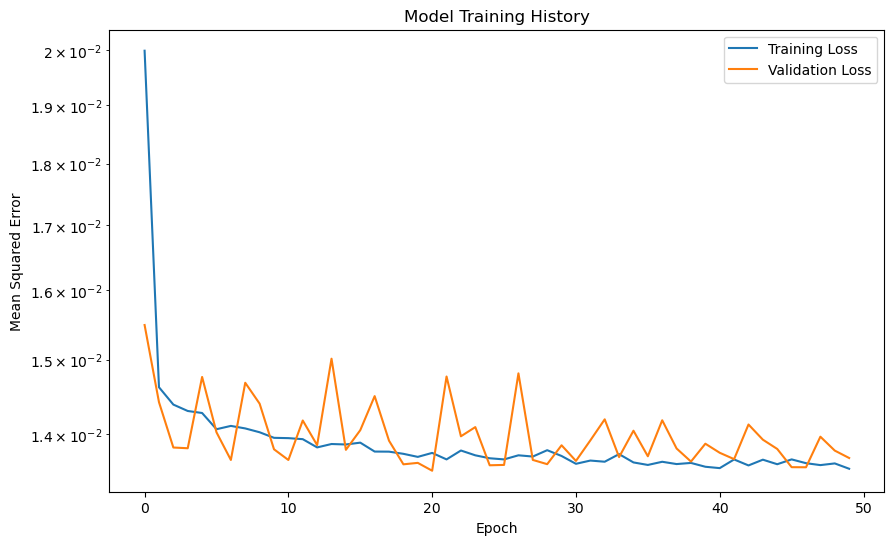

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.yscale('log')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

Compare the original function with the neural network predictions

686/686 [==============================] - 1s 1ms/step


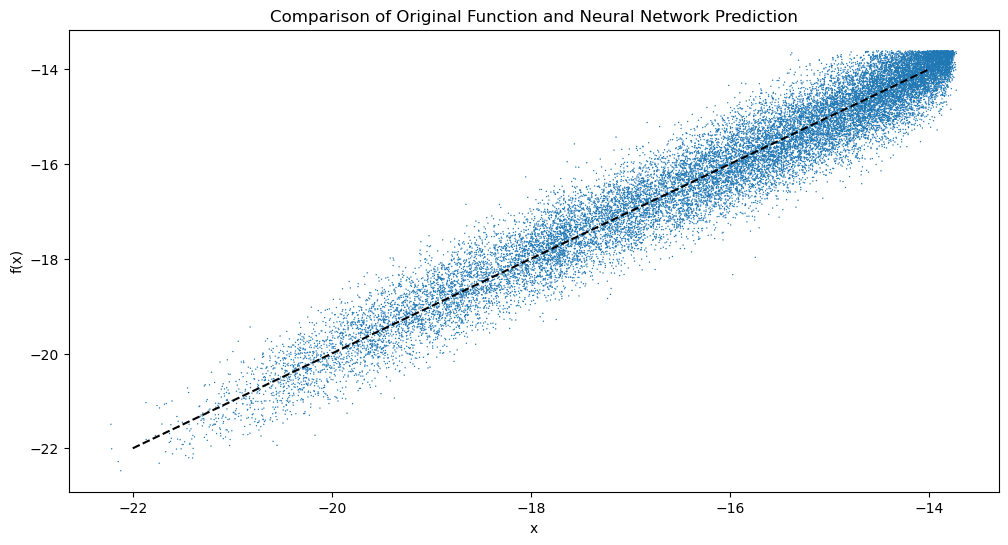

Mean Squared Error: 0.013458628388955332


In [7]:
plt.figure(figsize=(12, 6))

# read some new data that the model was not trained on
x_test, x_test_normalized, y_test, y_test_normalized = get_training_data(1, 1000)
y_pred_normalized = model.predict(x_test_normalized)

plt.scatter(y_pred_normalized*4 - 18, y_test_normalized*4 - 18, s=1, edgecolor='none')

plt.plot([-22,-14],[-22,-14], c='k', ls='--')

plt.title('Comparison of Original Function and Neural Network Prediction')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

# Calculate and print the mean squared error
mse = np.mean((y_test_normalized - y_pred_normalized.flatten())**2)
print(f"Mean Squared Error: {mse}")